In [63]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from xgboost import XGBClassifier
import seaborn as sns
import shap

In [64]:
df = pd.read_csv("Data/covid.csv")

# Data Exploration

In [65]:
df.shape

(566602, 23)

In [66]:
df.columns

Index(['id', 'sex', 'patient_type', 'entry_date', 'date_symptoms', 'date_died',
       'intubed', 'pneumonia', 'age', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu'],
      dtype='object')

In [67]:
df.head(15)

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2
5,1beec8,2,2,16-04-2020,16-04-2020,29-04-2020,2,1,47,97,...,2,2,2,2,2,2,2,99,1,1
6,1.75E+56,2,2,22-04-2020,13-04-2020,9999-99-99,2,2,63,97,...,2,1,2,2,2,2,2,99,1,2
7,0ce1f5,1,1,21-05-2020,18-05-2020,9999-99-99,97,2,56,2,...,2,1,2,2,2,1,1,1,1,97
8,12b57a,1,1,22-04-2020,18-04-2020,9999-99-99,97,2,41,2,...,2,2,2,2,2,2,2,99,1,97
9,006b91,1,2,23-04-2020,18-04-2020,9999-99-99,1,1,39,2,...,2,2,2,2,1,2,2,99,1,2


In [68]:
df.isnull().sum()

id                     0
sex                    0
patient_type           0
entry_date             0
date_symptoms          0
date_died              0
intubed                0
pneumonia              0
age                    0
pregnancy              0
diabetes               0
copd                   0
asthma                 0
inmsupr                0
hypertension           0
other_disease          0
cardiovascular         0
obesity                0
renal_chronic          0
tobacco                0
contact_other_covid    0
covid_res              0
icu                    0
dtype: int64

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566602 entries, 0 to 566601
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   566602 non-null  object
 1   sex                  566602 non-null  int64 
 2   patient_type         566602 non-null  int64 
 3   entry_date           566602 non-null  object
 4   date_symptoms        566602 non-null  object
 5   date_died            566602 non-null  object
 6   intubed              566602 non-null  int64 
 7   pneumonia            566602 non-null  int64 
 8   age                  566602 non-null  int64 
 9   pregnancy            566602 non-null  int64 
 10  diabetes             566602 non-null  int64 
 11  copd                 566602 non-null  int64 
 12  asthma               566602 non-null  int64 
 13  inmsupr              566602 non-null  int64 
 14  hypertension         566602 non-null  int64 
 15  other_disease        566602 non-nu

In [70]:
# How many female patients are pregnant

x = df.loc[(df.sex == 1) & (df.pregnancy == 1)]
print(len(x))

4063


In [71]:
# How many Covid positive patients were tobacco users

x = df.loc[(df.covid_res == 2) & (df.tobacco == 1)]
print(len(x))

25846


# Finding value counts of categorical variables

CLAVE	DESCRIPCIÓN
1	YES
2	NO
97	Not Applicable
98	Ignore
99	Not Specified

1	Female
2	Male
99	Not Specified

In [72]:
# Create a subset of categorical variables only
subset = df.drop(columns= ['date_died', 'entry_date', 'date_symptoms', 'id', 'age'])

In [73]:
for col in subset.columns:
    print(subset[col].value_counts())

2    287112
1    279490
Name: sex, dtype: int64
1    444689
2    121913
Name: patient_type, dtype: int64
97    444689
2     111824
1       9965
99       124
Name: intubed, dtype: int64
2     478416
1      88175
99        11
Name: pneumonia, dtype: int64
97    287112
2     273840
1       4063
98      1587
Name: pregnancy, dtype: int64
2     493790
1      70831
98      1981
Name: diabetes, dtype: int64
2     555723
1       9130
98      1749
Name: copd, dtype: int64
2     546824
1      18026
98      1752
Name: asthma, dtype: int64
2     555644
1       8978
98      1980
Name: inmsupr, dtype: int64
2     472270
1      92508
98      1824
Name: hypertension, dtype: int64
2     546920
1      17084
98      2598
Name: other_disease, dtype: int64
2     552005
1      12775
98      1822
Name: cardiovascular, dtype: int64
2     472549
1      92272
98      1781
Name: obesity, dtype: int64
2     553560
1      11250
98      1792
Name: renal_chronic, dtype: int64
2     516678
1      48017
98      1907
N

In [74]:
# Removing rows that have covid_res= 3 meaning 'pending'
index_names = df[ df['covid_res'] == 3 ].index
df.drop(index_names, inplace = True)

In [75]:
# Checking value_counts of covid_res column
df['covid_res'].value_counts()

2    279035
1    220657
Name: covid_res, dtype: int64

In [76]:
# Change date_died column to categorical data "9999-99-99" to 0 and row with date to 1
df.loc[df.date_died == "9999-99-99", "date_died"] = 0

In [77]:
df.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,0,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,0,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,0,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,0,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


In [78]:
df.loc[df.date_died != 0, "date_died"] = 1

In [79]:
df.head(10)

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,0,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,0,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,0,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,0,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,1,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2
5,1beec8,2,2,16-04-2020,16-04-2020,1,2,1,47,97,...,2,2,2,2,2,2,2,99,1,1
6,1.75E+56,2,2,22-04-2020,13-04-2020,0,2,2,63,97,...,2,1,2,2,2,2,2,99,1,2
7,0ce1f5,1,1,21-05-2020,18-05-2020,0,97,2,56,2,...,2,1,2,2,2,1,1,1,1,97
8,12b57a,1,1,22-04-2020,18-04-2020,0,97,2,41,2,...,2,2,2,2,2,2,2,99,1,97
9,006b91,1,2,23-04-2020,18-04-2020,0,1,1,39,2,...,2,2,2,2,1,2,2,99,1,2


In [80]:
df['date_died'].value_counts()

0    465571
1     34121
Name: date_died, dtype: int64

In [81]:
df["date_died"] = df["date_died"].astype("int64")

# Machine Learning

In [82]:
df = df.sample(n=10000)

In [83]:
# Create our features
# X = df.drop(columns= ['date_died', 'entry_date', 'date_symptoms', 'id', 'age'])
X = df.drop(columns= ['covid_res', 'date_died', 'entry_date', 'date_symptoms', 'id', 'age', 'patient_type', 
                      'intubed', 'icu', 'pneumonia','other_disease','sex'])

# Create our target
y = df['date_died']
#y = df['covid_res']

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.9, random_state=123, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6700, 11) (3300, 11) (6700,) (3300,)


In [85]:
X.dtypes

pregnancy              int64
diabetes               int64
copd                   int64
asthma                 int64
inmsupr                int64
hypertension           int64
cardiovascular         int64
obesity                int64
renal_chronic          int64
tobacco                int64
contact_other_covid    int64
dtype: object

In [86]:
categorical_features_indices = np.where(X.dtypes != np.float64)[0]
categorical_features_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [87]:
y.value_counts()

0    9322
1     678
Name: date_died, dtype: int64

# LightGBM Classifier

In [88]:
X.dtypes

pregnancy              int64
diabetes               int64
copd                   int64
asthma                 int64
inmsupr                int64
hypertension           int64
cardiovascular         int64
obesity                int64
renal_chronic          int64
tobacco                int64
contact_other_covid    int64
dtype: object

In [90]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[22:20:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [91]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.9379
Testing accuracy 0.9276


In [93]:
model.feature_importances_

array([0.06709719, 0.27575868, 0.06808674, 0.03289253, 0.04415782,
       0.07334989, 0.05651085, 0.04466802, 0.07161333, 0.04077187,
       0.22509308], dtype=float32)

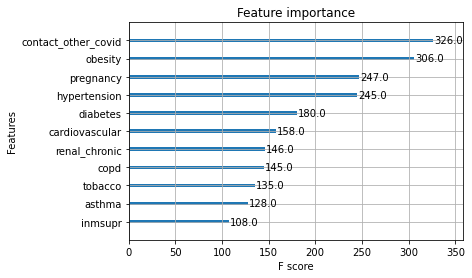

In [95]:
from xgboost import plot_importance
plot_importance(model)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


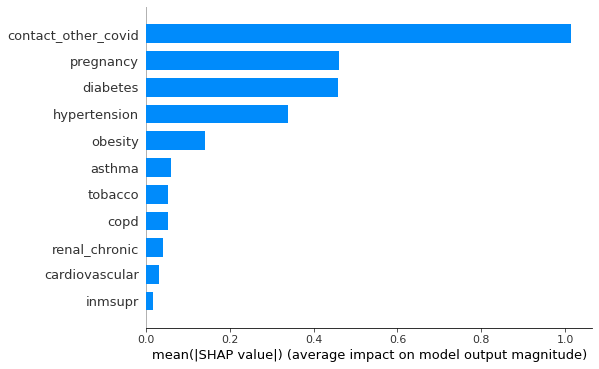

In [92]:
# Create a dataframe of feature importance 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [337]:
from sklearn.metrics import accuracy_score

print('the test accuracy is :{:.6f}'.format(accuracy_score(y_test, model.predict(X_test))))

the test accuracy is :0.931719
